In [4]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)

import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

from src.deep_learning.splitter.splitter_datasets import create_data_for_splitter
from src.metadata_processing.load_data import load_recordings_metadata, load_sounds

%load_ext autoreload
%autoreload 2
%matplotlib inline


/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# what data to load
dates = 'all'
colonies = ['arryn', 'stark', 'baratheon', 'martell', 'lannister', 'targaryen', 'tyrell']
experiments = 'all'
stages = ['traced and checked', 'labeled and checked', 'split and checked']

# Denoising parameters
use_rec_denoising = False
rec_denoising_params = {'stationary': False, 'n_fft': 512, 'time_constant_s': 0.05, 
                        'freq_mask_smooth_hz': 500, 'time_mask_smooth_ms': 10}
# Sounds metadata parameters
classes_to_drop = ['weirdo', 'badsplit']
max_sounds_per_class = {'softchirp': 20000}
max_sound_length = 9000
min_sound_length = 1337
train_ratio = 0.92
columns_to_copy = ['colony', 'ratids', 'date', 'experiment']

# Splitting params
resolution = 2048
step = 1024

# Sounds metadata parameters
classes_balance_factor = 5/7
train_ratio = .7
columns_to_copy = ['colony', 'ratids', 'date', 'experiment']

# Data augmentation parameters
wave_augment_params = {'augment': False, 
                       'times_each_sound': 1, 
                       'stretching_lims': None,
                       'add_noise_lims': (0.001, 0.005), }
times_augment_im = 5
augment_im = True

# Processing features
extract_specs_params = {'num_freq_bins': 128,
                        'num_time_bins': 16,
                        'nperseg': 512, 
                        'noverlap': None, 
                        'min_freq': 3000,
                        'max_freq': 11025,
                        'spec_min_val': -10, 
                        'spec_max_val': 0,
                        'remove_dc_offset': True, 
                        'mel': False, 
                        'max_dur': 0.4, 
                        'time_stretch': True}
sr = 22050
highpass_filtering = 3000
specs_type = 'new-specs' # 'mel' , 'specs', 'new-specs'
target_shape = (extract_specs_params['num_freq_bins'], extract_specs_params['num_time_bins'])

# Where to save
data_str = 'african'
path_to_save = PATH_TO_PROJECT + 'models/splitter/deep_splitter/datasets/'
dataset_name = '%s_%s_res=%d_step%d_nfft=%d_shape=%s_denoise=%s_hpass=%s' % (data_str, specs_type, resolution,
                                                                             step, extract_specs_params['nperseg'],
                                                                             target_shape,  use_rec_denoising, 
                                                                             highpass_filtering)
print(dataset_name)

african_new-specs_res=2048_step1024_nfft=512_shape=(128, 16)_denoise=False_hpass=3000


In [10]:
all_params_dict = {'sr': sr,
                   
                   'recs_metadata': 
                       {'dates': dates, 'colonies': colonies, 'experiments': experiments, 'stages': stages,
                        'path_to_recordings_metadata': path_to_recordings_metadata, 
                        'recordings_metadata_name': recordings_metadata_name},
                   
                  'rec_denoising':
                       {'use_rec_denoising': use_rec_denoising, 'rec_denoising_params': rec_denoising_params},
                   
                   'sounds_metadata':
                   {'classes_to_drop': classes_to_drop, 'max_sounds_per_class': max_sounds_per_class, 
                    'max_sound_length': max_sound_length, 'min_sound_length': min_sound_length, 
                    'train_ratio': train_ratio, 'columns_to_copy': columns_to_copy},
                   
                  'features': {'resolution':resolution, 'step': step, 'target_shape': target_shape,
                               'highpass_filtering': highpass_filtering,
                               'wave_augment_params': wave_augment_params, 
                               'extract_specs_params': extract_specs_params,
                                'times_augment_im': times_augment_im, 'augment_im': augment_im,
                               'specs_type': specs_type}}

In [11]:
recs_metadata, recs_dict = load_recordings_metadata(path_to_recordings_metadata, recordings_metadata_name,
                                           dates, colonies, experiments, stages)
if use_rec_denoising:
    recs_dict = {rec_name: denoise_recording(rec, sr, **rec_denoising_params) 
                 for rec_name, rec in recs_dict.items()}
recs_metadata.head()

Using 904 recordings


,colony,date,experiment,name,number,path,processing stage,ratids
0,targaryen,21-06-19,single rat softchirps,targaryen_21-06-19_1540_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/targar...,traced and checked,1540
1,stark,21-06-19,single rat softchirps,stark_21-06-19_1545_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/stark/...,labeled and checked,1545
2,targaryen,08-11-19,single rat softchirps,targaryen_08-11-19_1538_0000085.npy,85.0,/home/gr1/Projects/naked-mole-rats/data/targar...,traced and checked,1538
3,targaryen,08-11-19,single rat softchirps,targaryen_08-11-19_4030_0000097.npy,97.0,/home/gr1/Projects/naked-mole-rats/data/targar...,traced and checked,4030
4,targaryen,15-05-19,single rat softchirps,targaryen_15-05-19_1411_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/targar...,traced and checked,1411


In [ ]:
(sounds_metadata_train, sounds_npy_train, melspecs_train,
 sounds_metadata_test,  sounds_npy_test, melspecs_test) =  create_data_for_splitter(all_params_dict, 
                                                                                    dataset_name,  
                                                                                    path_to_save, save=True,
                                                                                    preloaded_recs_dict=recs_dict)

Using 904 recordings


/home/gr1/Projects/naked-mole-rats/src/metadata_processing/process_sounds_metadata.py:37: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sounds_metadata = pd.concat(sounds_metadata, 0).reset_index(drop=True)


Using 594 recordings (31840 sounds)for train and  255 recordings (16011 sounds)for test

############ Classes in train:############ 

noise              15626
softchirp          14181
downsweep            551
pupcombo             365
whistle              267
combo                122
combotwo             119
grunt                109
pupcheveron          102
scream                91
upsweep               85
loudchirp             67
pupsquawk             66
phee                  24
mordent               13
RFIDscanner           13
vtrill                13
hiccup                13
tweet                  8
invertedmordent        5
Name: cl, dtype: int64
############ Classes in test: ############ 

noise              9436
softchirp          5622
pupcombo            241
downsweep           194
combotwo            126
combo               105
pupcheveron          66
loudchirp            51
grunt                48
whistle              47
upsweep              26
pupsquawk            20
hiccup    

/home/gr1/Projects/naked-mole-rats/src/deep_learning/splitter/splitter_datasets.py:82: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sounds_metadata_train = pd.concat([sounds_metadata_train] * times_augment_im, 0)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
# Print bincounts
img_shape = melspecs_train.shape[1:]
y_train_str = sounds_metadata_train['cl']
y_test_str = sounds_metadata_test['cl']
all_classes_str = sorted(list(set(y_train_str.unique()) | set(y_test_str.unique())))
y_train = y_train_str.apply(lambda x: all_classes_str.index(x))
y_test = y_test_str.apply(lambda x: all_classes_str.index(x))
print(np.bincount(y_train))
print(np.bincount(y_test))

[ 475  290 6440   30 1870   45  835   35  955  225  145  370   40 5710]
[ 41  39 453   6  93  14  91   5  75  68  34  15  38 620]


In [12]:
y_train

0       8
1       8
2       8
3       2
4       2
       ..
3488    6
3489    6
3490    2
3491    2
3492    2
Name: cl, Length: 17465, dtype: int64

In [13]:
all_classes_str

['combo',
 'combotwo',
 'downsweep',
 'grunt',
 'loudchirp',
 'mordent',
 'phee',
 'scream',
 'softchirp',
 'tweet',
 'upsweep',
 'vtrill',
 'warble',
 'whistle']

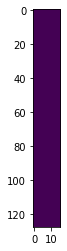

In [9]:
plt.imshow(melspecs_train[1230])

In [10]:
    df_txt = create_txt(rec_labels, th, min_length=min_length, sr=sr)
    df_txt = broaden_timestamps(df_txt, rec, each_side=broaden_factor, sr=sr)

    rec_labels = np.zeros(len(rec), dtype='int')
    for s, e, cl in df_txt.values:
        if cl == 'sound':
            s_rec, e_rec = int(sr * s), int(sr * e)
            rec_labels[s_rec: e_rec] = 1

    img_labels = []
    for ind in np.arange(0, len(rec) - px_to_smp, px_to_smp):
        pixel_label = np.mean(rec_labels[int(ind): int(ind + px_to_smp)])
        img_labels.append(pixel_label)
    img_labels = np.array(img_labels)

NameError: name 'create_txt' is not defined